<a href="https://colab.research.google.com/github/yenjannn/project1/blob/master/1002__Complete_project_mobilenetv2_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1.Import Package

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt

import itertools
import random
import seaborn as sns
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow import Tensor
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization, Add, AveragePooling2D, Flatten, Dense, GlobalAveragePooling2D ,concatenate,MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

from keras import backend as K
from keras.models import load_model
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

import cv2
from PIL import Image
import glob
from ipywidgets import interact_manual

from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

## 2.Load and Reshape Image Data
### a. Mount Drive (Optional)
### b. Load from Local

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = "/content/drive/My Drive/綠島海底特有生物AI辨識/"
x = np.load(os.path.join(dataset_path, "1002_96X128_image.npy"))
y = np.load(os.path.join(dataset_path, "1002_96X128_label.npy"))

In [ ]:
# 各類別數量
unique, counts = np.unique(y, return_counts=True)  # return_index=True表示返回新清單元素在舊清單中的位置
A = dict(zip(unique, counts))
print(min(A, key=A.get))  # 最小values所對應到的key
print(min(zip(A.keys(), A.values())))  #以放前面的為最小值(不是我要的) 
print(min(zip(A.values(), A.keys())))
print(A)

# import collections
# from collections import Counter
# collections.Counter(y)

11.0
(1.0, 923)
(43, 11.0)
{1.0: 923, 2.0: 156, 3.0: 87, 4.0: 506, 5.0: 562, 6.0: 45, 7.0: 116, 8.0: 257, 9.0: 172, 10.0: 46, 11.0: 43, 12.0: 97, 13.0: 55, 14.0: 329, 15.0: 57, 16.0: 304, 17.0: 180, 18.0: 322, 19.0: 170, 20.0: 431, 21.0: 133, 22.0: 469, 23.0: 275, 24.0: 216, 25.0: 314, 26.0: 406, 27.0: 252, 28.0: 402, 29.0: 58, 30.0: 333, 31.0: 502, 32.0: 141, 33.0: 440, 34.0: 183, 35.0: 273, 36.0: 254, 37.0: 183, 38.0: 78, 39.0: 89, 40.0: 321, 41.0: 383}


(array([923., 156.,  87., 506., 562.,  45., 116., 257., 172.,  46.,  43.,
         97.,  55., 329.,  57., 304., 180., 322., 170., 431., 133., 469.,
        275., 216., 314., 406., 252., 402.,  58., 333., 502., 141., 440.,
        183., 273., 254., 183.,  78.,  89., 321., 383.]),
 array([ 1.        ,  1.97560976,  2.95121951,  3.92682927,  4.90243902,
         5.87804878,  6.85365854,  7.82926829,  8.80487805,  9.7804878 ,
        10.75609756, 11.73170732, 12.70731707, 13.68292683, 14.65853659,
        15.63414634, 16.6097561 , 17.58536585, 18.56097561, 19.53658537,
        20.51219512, 21.48780488, 22.46341463, 23.43902439, 24.41463415,
        25.3902439 , 26.36585366, 27.34146341, 28.31707317, 29.29268293,
        30.26829268, 31.24390244, 32.2195122 , 33.19512195, 34.17073171,
        35.14634146, 36.12195122, 37.09756098, 38.07317073, 39.04878049,
        40.02439024, 41.        ]),
 <a list of 41 Patch objects>)

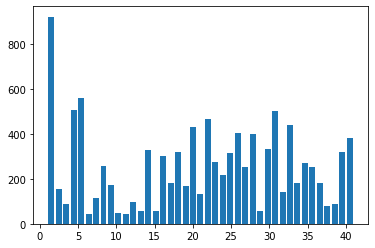

In [ ]:
# 單一物種圖片數量長條圖
plt.hist(y, bins=41, rwidth=0.8)

In [ ]:
# 設新的 random_state
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1996)

In [ ]:
df_count_train

## 3.Generate Triplet Data by Data Generator
* Ref: https://blog.csdn.net/yjy728/article/details/79571138
* Ref: https://blog.csdn.net/m0_37477175/article/details/79716312
* Ref: https://stackoverflow.com/questions/46493419/use-a-generator-for-keras-model-fit-generator/46497414#46497414

In [ ]:
def datagenerator(images, labels, mode="train", testsize=0.3, ap_pairs=8, an_pairs=8):  # 一個batchsize(ap_pairs*an_pairs*testsize)
                                                  #triplet總數太多，可以不用特別設定testsize
    while True:

        data_xy = tuple([images, labels])

        trainsize = 1-testsize
        # sorted(): 對所有可反覆運算的物件進行排序操作
        for data_class in sorted(set(data_xy[1])):
          triplet_Anchor_pairs = []
          triplet_Positive_pairs = []
          triplet_Negative_pairs = []
          # Collect indices(索引) of anchor/positive and negative classes
          # data_xy[1] 是指 tuple([x, y]) 中的 y
          # np.where(condition): 只有條件 (condition)，沒有x和y，則輸出滿足條件 (即非0) 元素的座標 (等價於numpy.nonzero)
          # 這裡的座標以tuple的形式給出，通常原陣列有多少維，輸出的tuple中就包含幾個陣列，分別對應符合條件元素的各維座標。
          same_class_idx = np.where((data_xy[1]==data_class))[0]
          diff_class_idx = np.where(data_xy[1]!=data_class)[0]

          # Generating Anchor-Positive pairs
          # itertools.permutations( , 2): 資料取兩個兩個取出來排列
          # random.sample(data, k)  k: 從data中，取出k個資料出來
          A_P_pairs = random.sample(list(itertools.permutations(same_class_idx, 2)), k=ap_pairs)
          Neg_idx = random.sample(list(diff_class_idx), k=an_pairs)
              
          A_P_pairs = A_P_pairs
          Neg_idx = Neg_idx 
          # START
          # Create training set
          A_P_len = len(A_P_pairs)
          Neg_len = len(Neg_idx)

          for ap in A_P_pairs[:int((A_P_len)*trainsize)]:
              Anchor = data_xy[0][ap[0]]
              Positive = data_xy[0][ap[1]]
              for n in Neg_idx:
                  Negative = data_xy[0][n]
                  triplet_Anchor_pairs.append(Anchor)
                  triplet_Positive_pairs.append(Positive)
                  triplet_Negative_pairs.append(Negative)
              
          yield [np.array(triplet_Anchor_pairs), np.array(triplet_Positive_pairs), np.array(triplet_Negative_pairs)], np.empty((int(testsize*ap_pairs*an_pairs), 150))
          # np.empty(,150)是亂數，因為datagenerator一定要有labels的輸出，所以這個部分不可信

In [ ]:
# Normalize data into [0, 1]
sc_img = MinMaxScaler()
# np.prod() 函数計算數組元素乘積等
image_normalized = sc_img.fit_transform(x.reshape(-1, np.prod(x.shape[1:]))).reshape(x.shape)

In [ ]:
image_list = x
label_list = y

In [ ]:
datagen = datagenerator(image_normalized ,label_list)

In [ ]:
print(type(datagen))

<class 'generator'>


## 4.Define and Train FaceNet

In [ ]:
# Mobile net
MobilenetV2_model = tf.keras.applications.MobileNetV2(
    input_shape=(128 , 96 , 3),
    alpha=1.0,
    #depth_multiplier=1,
    #dropout=0.001,
    #include_top=True,
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    pooling='avg',
    #classes=36,
    classifier_activation="softmax",
)

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
MobilenetV2_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 96, 3)] 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 97, 3)   0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 48, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 48, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [ ]:
# (None, 1280) → (None, 128)
# add_layers = [Input(shape=(None, 1280)), Dense(units=128, activation='relu')]

#add_layers = [Input(shape=(None, 1280))]

In [ ]:
#MobilenetV2_model + add_layers

model_3 = tf.keras.models.Sequential()  # triplet_NN.layers[0] = x_a, x_a = Input(shape=img_shape, name='anchor_input')

model = MobilenetV2_model
model_3.add(model)
#model_3.add(add_layers[0])  # x_a: input layer
#model_3.add(add_layers[1])

model_3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
Total params: 2,257,984
Trainable params: 2,223,872
Non-trainable params: 34,112
_________________________________________________________________


In [ ]:
(next(datagen)[0][0]).shape # tf.Tensor 'mobilenetv2_1.00_128/out_relu/Relu6:0' shape=(40, 4, 3, 1280) dtype=float32>

(40, 128, 96, 3)

In [ ]:
#tf.keras.applications.mobilenet.summary()
#AttributeError: module 'tensorflow.keras.applications.mobilenet' has no attribute 'summary'


img_shape = next(datagen)[0][0].shape[1:]  # 只要shape正確即可
x_a = Input(shape=img_shape, name='anchor_input')
x_p = Input(shape=img_shape, name='positive_input')
x_n = Input(shape=img_shape, name='negative_input')

y_a = model_3(x_a)
y_p = model_3(x_p)
y_n = model_3(x_n)

merged_vector = concatenate([y_a, y_p, y_n], axis=-1, name='merged_layer')

# Keras的函數式模型為Model，即廣義的擁有輸入和輸出的模型，我們使用Model來初始化一個函數式模型  Model(inputs, outputs)
triplet_NN_try = Model(inputs=[x_a, x_p, x_n], outputs=merged_vector)
triplet_NN_try.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       [(None, 128, 96, 3)] 0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     [(None, 128, 96, 3)] 0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     [(None, 128, 96, 3)] 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 1280)         2257984     anchor_input[0][0]               
                                                                 positive_input[0][0]  

In [ ]:
def triplet_loss(y_true, y_pred, alpha = 0.1):
    """
    Implementation of the triplet loss function
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor data
            positive -- the encodings for the positive data (similar to anchor)
            negative -- the encodings for the negative data (different from anchor)
    Returns:
    loss -- real number, value of the loss
    """
    
    total_lenght = y_pred.shape.as_list()[-1]
    
    anchor = y_pred[:,0:int(total_lenght*1/3)]
    positive = y_pred[:,int(total_lenght*1/3):int(total_lenght*2/3)]
    negative = y_pred[:,int(total_lenght*2/3):int(total_lenght*3/3)]

    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)

    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)

    # compute loss
    basic_loss = pos_dist - neg_dist + alpha
    loss = K.maximum(basic_loss, 0.0)
 
    return loss

In [ ]:
triplet_NN_try.compile(loss=triplet_loss, optimizer=Adam())

In [ ]:
history = triplet_NN_try.fit(datagen, steps_per_epoch=185 ,epochs=5)

Epoch 1/5
185/185 [==============================] - 57s 310ms/step - loss: 11.4358
Epoch 2/5
185/185 [==============================] - 58s 312ms/step - loss: 0.3733
Epoch 3/5
185/185 [==============================] - 58s 312ms/step - loss: 0.0915
Epoch 4/5
185/185 [==============================] - 58s 313ms/step - loss: 0.0496
Epoch 5/5
185/185 [==============================] - 58s 312ms/step - loss: 0.0337


## 5.Visualize

In [ ]:
def scatter(x, labels, subtitle=None):
    # Compute the number of classes
    C = int(labels.max() - labels.min())

    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 60))  # 總數41種,因為有一個種類數量是零張(但要設數字大，不然有問題)

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:, 0], x[:, 1], lw=0, s=40,
                    c=palette[labels.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(C):
        # Position of each label.
        xtext, ytext = np.median(x[labels==i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
        
    if subtitle != None:
        plt.suptitle(subtitle)
        
    plt.savefig(subtitle)

In [ ]:
# print(len(image_normalized))
# print(len(image_normalized))

In [ ]:
tsne = TSNE()
train_tsne = tsne.fit_transform(image_normalized[7500:].reshape(-1, np.prod(image_normalized[7500:].shape[1:])))

tsne = TSNE()
X_train_trm = MobilenetV2_model.predict(image_normalized[7500:])
train_tsne_embeds = tsne.fit_transform(X_train_trm)

In [ ]:
# tsne = TSNE()
# train_tsne = tsne.fit_transform(image_normalized.reshape(-1, np.prod(image_normalized.shape[1:])))

# tsne = TSNE()
# X_train_trm = model.predict(image_normalized)
# train_tsne_embeds = tsne.fit_transform(X_train_trm)

In [ ]:
# print(len(train_tsne))
# print(len(label_list[:100]))

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


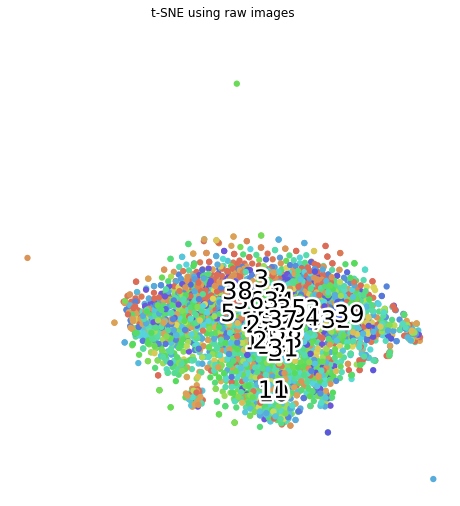

posx and posy should be finite values
posx and posy should be finite values


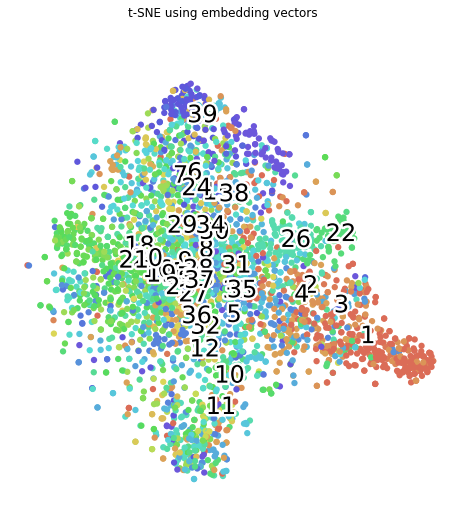

In [ ]:
scatter(train_tsne, label_list[7500:], "t-SNE using raw images")
scatter(train_tsne_embeds, label_list[7500:], "t-SNE using embedding vectors")

## 5.Save Model

In [ ]:
# triplet_NN.save("/content/drive/My Drive/Lab_Green_Island/0914_tripletNN_model.h5")
#triplet_NN_try.save("/content/drive/My Drive/綠島海底特有生物AI辨識/暫存code/1002_tripletNN_model_mobilenetv2_v1.h5")

## 6.Load the Model 

In [ ]:
# Load triplet_NN model
# triplet_NN = load_model("/content/drive/My Drive/Lab_Green_Island/0914_tripletNN_model.h5", custom_objects={'triplet_loss':triplet_loss})
triplet_NN = load_model("/content/drive/My Drive/綠島海底特有生物AI辨識/暫存code/1002_tripletNN_model_mobilenetv2_v1.h5", custom_objects={'triplet_loss':triplet_loss})


##7.Define a Classification Model which Combines the FaceNet Model and the Fully-connected layer   

In [ ]:
triplet_NN.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       [(None, 128, 96, 3)] 0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     [(None, 128, 96, 3)] 0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     [(None, 128, 96, 3)] 0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 1280)         2257984     anchor_input[0][0]               
                                                                 positive_input[0][0]  

In [ ]:
triplet_NN.layers

In [ ]:
model_3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
Total params: 2,257,984
Trainable params: 2,223,872
Non-trainable params: 34,112
_________________________________________________________________


In [ ]:
FC_layers = [Input(shape=(None, 1280)), Dense(units=41, activation='softmax')]

model_2 = tf.keras.models.Sequential()  # triplet_NN.layers[0] = x_a, x_a = Input(shape=img_shape, name='anchor_input')
#model = create_res_net(next(datagen)[0][0])
# model = MobilenetV2_model
model = model_3

#model_2.add(triplet_NN.layers[0])  # x_a: input layer
model_2.add(model)
model_2.add(FC_layers[0])
model_2.add(FC_layers[1])

model_2.summary()
model_2.compile(loss='categorical_crossentropy', 
                optimizer=Adam(),
                metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 1280)              2257984   
_________________________________________________________________
input_2 (InputLayer)         multiple                  0         
_________________________________________________________________
dense (Dense)                (None, 41)                52521     
Total params: 2,310,505
Trainable params: 2,276,393
Non-trainable params: 34,112
_________________________________________________________________


##8.Train the Classification Model and Save It

In [ ]:
y_train_cla = y_train - 1
y_test_cla = y_test - 1

y_train_cla = to_categorical(y_train_cla,num_classes = 41)
y_test_cla = to_categorical(y_test_cla,41)

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=4, 
    verbose=0, 
    mode='auto')

model_2_history =  model_2.fit(x_train, y_train_cla,
            # batch_size=128,
            batch_size=160,
            epochs=200,
            validation_data=(x_test, y_test_cla))
            #callbacks=[early_stopping])

Epoch 1/200
53/53 [==============================] - 23s 437ms/step - loss: 1.6452 - accuracy: 0.5428 - val_loss: 3.7604 - val_accuracy: 0.1917
Epoch 2/200
53/53 [==============================] - 21s 396ms/step - loss: 0.7155 - accuracy: 0.7762 - val_loss: 5.4845 - val_accuracy: 0.1585
Epoch 3/200
53/53 [==============================] - 21s 396ms/step - loss: 0.5008 - accuracy: 0.8305 - val_loss: 4.1954 - val_accuracy: 0.2522
Epoch 4/200
53/53 [==============================] - 21s 401ms/step - loss: 0.4074 - accuracy: 0.8579 - val_loss: 5.7293 - val_accuracy: 0.1519
Epoch 5/200
53/53 [==============================] - 21s 398ms/step - loss: 0.3456 - accuracy: 0.8756 - val_loss: 4.9606 - val_accuracy: 0.2390
Epoch 6/200
53/53 [==============================] - 21s 396ms/step - loss: 0.3016 - accuracy: 0.8951 - val_loss: 6.9636 - val_accuracy: 0.2111
Epoch 7/200
53/53 [==============================] - 21s 401ms/step - loss: 0.2897 - accuracy: 0.8955 - val_loss: 4.3105 - val_accuracy:

In [ ]:
model_2_history.history.keys()

NameError: ignored

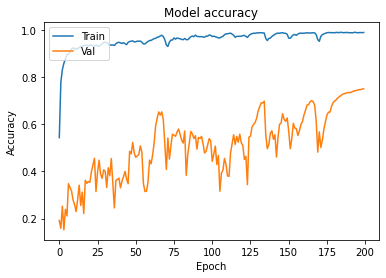

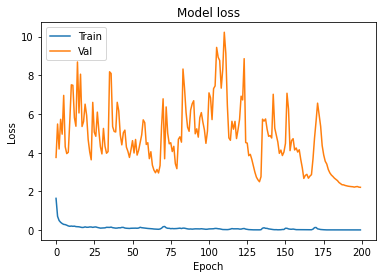

In [ ]:
# 分兩張圖，繪製accuracy & loss
plt.plot(model_2_history.history['accuracy'])
plt.plot(model_2_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(model_2_history.history['loss'])
plt.plot(model_2_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
#model_2.save("/content/drive/My Drive/綠島海底特有生物AI辨識/暫存code/1002_model_2_mobilenetV2_v3.h5")  # save classification model
#model_2.save("/content/drive/My Drive/Lab_Green_Island/0901_model_2.h5")  # save classification model

## 9.Load the Classification Model

In [ ]:
classifier = load_model("/content/drive/My Drive/綠島海底特有生物AI辨識/暫存code/1002_model_2_mobilenetV2_v3.h5")
classifier.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 1280)              2257984   
_________________________________________________________________
input_4 (InputLayer)         multiple                  0         
_________________________________________________________________
dense_1 (Dense)              (None, 41)                52521     
Total params: 2,310,505
Trainable params: 2,276,393
Non-trainable params: 34,112
_________________________________________________________________


## 10. Show the Classifying Result
* 學長要的統計資料

In [ ]:
# 設新的 random_state
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1996)
print(y_train)

from collections import Counter
#print(Counter(y_train))
count_train = Counter(y_train)
count_val = Counter(y_test)
count_all = Counter(y)

df_count_train = pd.DataFrame(count_train.items(), columns=['index', '# of Train.']).sort_values(by=['index'], ascending=True)
df_count_val = pd.DataFrame(count_val.items(), columns=['index_val', '# of Val.']).sort_values(by=['index_val'], ascending=True)
df_count_all = pd.DataFrame(count_all.items(), columns=['index_all', 'quantity.']).sort_values(by=['index_all'], ascending=True)
# inplace默認為False,如果該值為False，那麼原來的pd順序沒變
#df_count_train.set_index("index", inplace=True)  # df.reset_index(inplace=True): 讓index重置成原本的樣子！
df_count_train.set_index('index', inplace=True)
df_count_val.set_index('index_val', inplace=True)
df_count_all.set_index('index_all', inplace=True)


[31. 31. 40. ... 32. 26. 33.]


,# of Train.,# of Val.,quantity.
index,,,
1,739,184,923
2,120,36,156
3,73,14,87
4,407,99,506
5,459,103,562
6,32,13,45
7,93,23,116
8,204,53,257
9,148,24,172


In [ ]:
#result = classifier.predict_classes(x_test)

train_result = np.argmax(classifier.predict(x_train), axis=-1)+1
val_result = np.argmax(classifier.predict(x_test), axis=-1)+1
all_result = np.argmax(classifier.predict(x), axis=-1)+1


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score

# Calculating Test accuracy(不是我們要的!)
# 分類準確率分數是指所有分類正確的百分比。分類準確率這一衡量分類器的標準比較容易理解，但是它不能告訴你響應值的潛在分佈，並且它也不能告訴你分類器犯錯的類型。
# accuracy = accuracy_score(y_test, result)
# print("Accuracy: {:.2f}%".format(accuracy*100))

# 這才是各類正確比率
# recall =提取出的正確資訊條數 /樣本中的資訊條數。通俗地說，就是所有準確的條目有多少被檢索出來了
train_acc = recall_score(y_train, train_result, average=None)
val_acc = recall_score(y_test, val_result, average=None)
all_acc = recall_score(y, all_result, average=None)

dict = {"Training Acc.": train_acc,
        "# of Train.": (df_count_train.values).flatten(),
        "Val. Acc.": val_acc,
        "# of Val.": (df_count_val.values).flatten(),
        "Overall Acc.": all_acc,
        "Overall Ratio(%)": ((df_count_all.div(df_count_all.sum(axis=0), axis=1)*100).values).flatten()}
df = pd.DataFrame(dict)
#df.round(4)

In [ ]:
dataset_path=r'/content/drive/My Drive/綠島海底特有生物AI辨識/綠島生物現有種類爬蟲圖片/'
df_0 = pd.read_excel(dataset_path+'生物種類.xlsx')
df_count = pd.concat([df_0, df.round(4)], axis=1)

#df_count.to_excel(r"/content/drive/My Drive/綠島海底特有生物AI辨識/綠島生物現有種類爬蟲圖片/生物種類.xlsx",index=False)

In [ ]:
data = dict()
data['y_Actual'] = y_test
data['y_Predicted'] = result

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
#df

confusion_matrix_try = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'], normalize='index')# normalize='index': 每列總合為1
print(confusion_matrix_try)

Predicted        1         2         3   ...        39        40        41
Actual                                   ...                              
1.0        0.907609  0.043478  0.000000  ...  0.000000  0.000000  0.005435
2.0        0.222222  0.722222  0.055556  ...  0.000000  0.000000  0.000000
3.0        0.000000  0.142857  0.642857  ...  0.000000  0.000000  0.000000
4.0        0.070707  0.020202  0.010101  ...  0.000000  0.000000  0.000000
5.0        0.019417  0.000000  0.000000  ...  0.000000  0.000000  0.000000
6.0        0.000000  0.000000  0.000000  ...  0.000000  0.076923  0.000000
7.0        0.000000  0.000000  0.000000  ...  0.000000  0.565217  0.000000
8.0        0.000000  0.000000  0.000000  ...  0.000000  0.056604  0.000000
9.0        0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000
10.0       0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000
11.0       0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000
12.0       0.071429  0.00

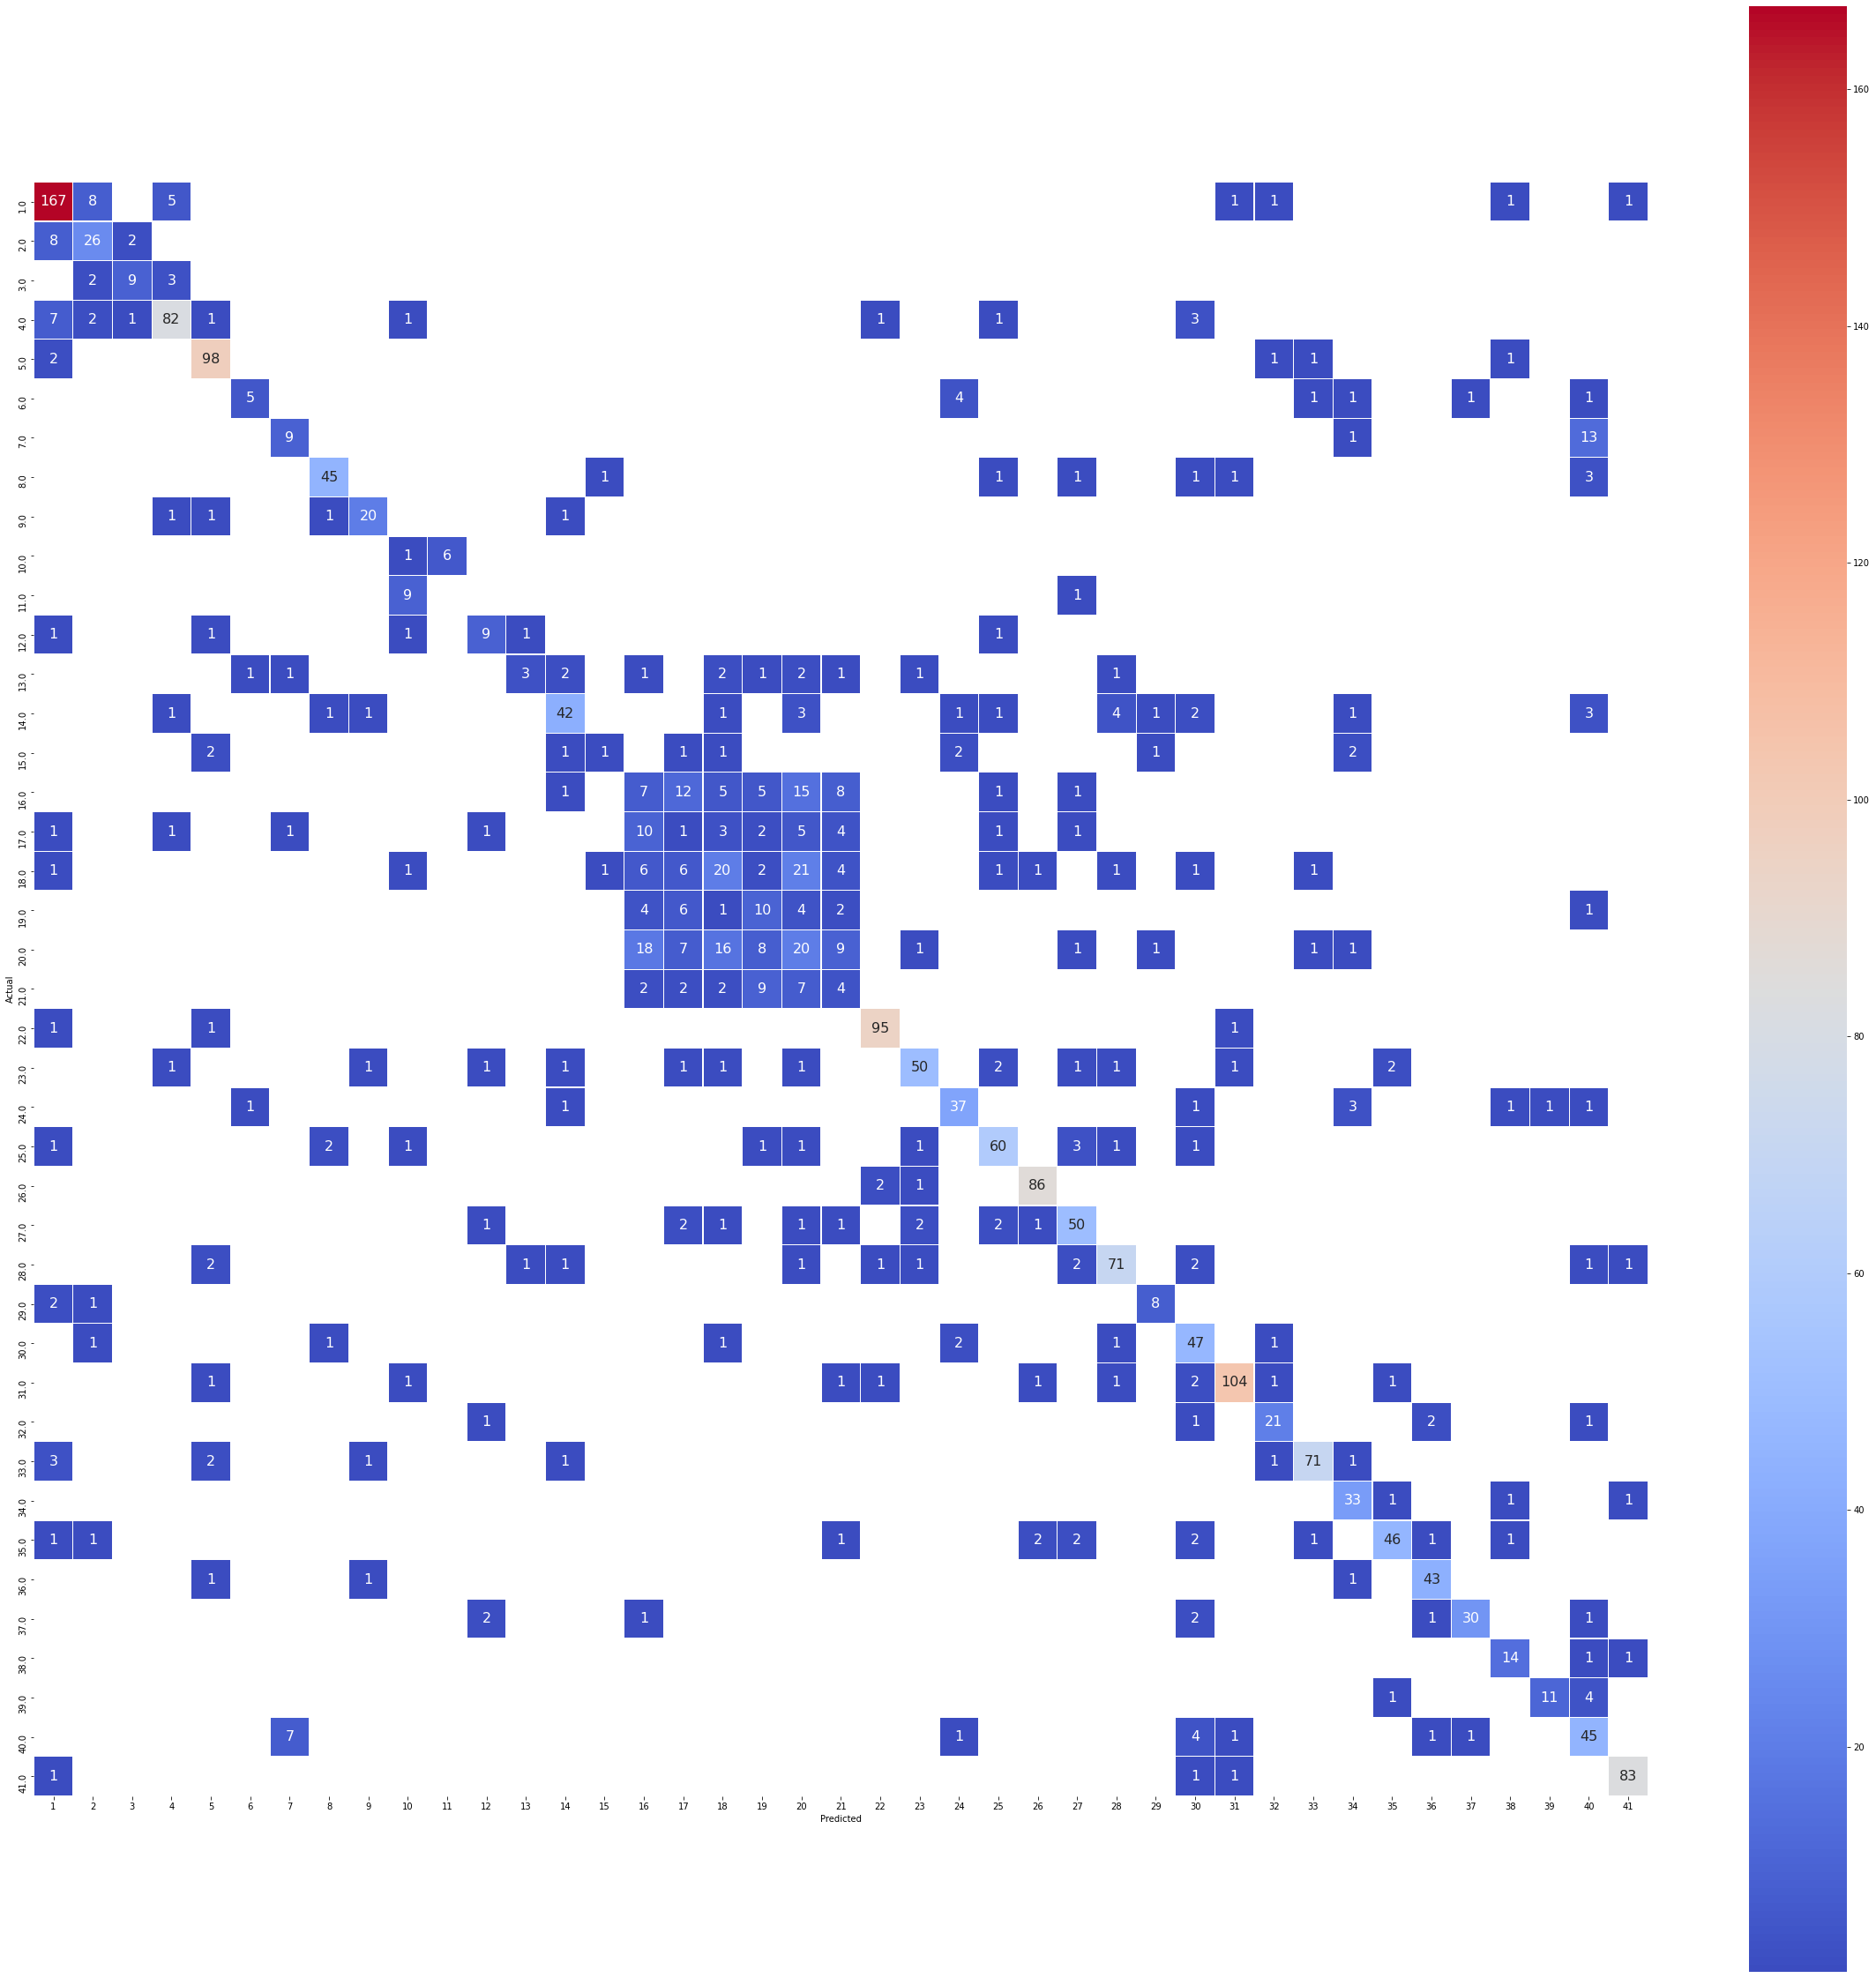

In [ ]:
# sns.heatmap(confusion_matrix, cmap='Blues')
# sns.heatmap(confusion_matrix, cmap='Blues')
f, ax = plt.subplots(figsize=(41, 41))
sns.heatmap(confusion_matrix, 
      mask=confusion_matrix < 1, 
      annot=True, 
      fmt='g', 
      annot_kws={'size':16}, 
      square=True, 
      linewidths=0.2, 
      cmap='Blues',
      vmin=0,
      vmax=180,
      center=50)
plt.show()

# f, ax = plt.subplots(figsize=(36, 36))
# sns.heatmap(confusion_matrix, annot=True, fmt='.1f', annot_kws={'size':15}, square=True, linewidths=0.2, cmap='Blues')
# plt.show()

In [ ]:
# Use ratio to show the confusion matrix
f, ax = plt.subplots(figsize=(41, 41))
sns.heatmap(confusion_matrix_try, 
      confusion_matrix_try < 0.01, 
      annot=True, 
      fmt='.2f', 
      annot_kws={'size':16}, 
      square=True, 
      linewidths=0.2, 
      cmap='YlOrRd',
      vmin=0,
      vmax=1,
      center=0.6)#center數值可以取對角線上機率的最小值
plt.show()

## 11.Visualize the Results

In [ ]:
Final_df.head(5)

,Training Acc.,Val. Acc.,Overall Acc.,# of Train.,# of Val.,quantity.
index,,,,,,
1,0.993234,0.907609,0.976165,739,184,923
2,0.991667,0.722222,0.929487,120,36,156
3,0.890411,0.642857,0.850575,73,14,87
4,0.980344,0.828283,0.950593,407,99,506
5,1.000000,0.951456,0.991103,459,103,562


### 下面這個還需要調整，縱軸座標應為比例

Text(0.5, 1.0, 'predicted')

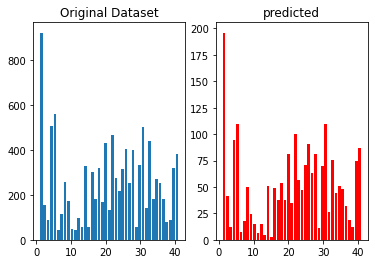

In [ ]:
# 預測結果的圖片數量長條圖
plt.subplot(121)
plt.hist(y, bins=41, rwidth=0.8)
plt.title("Original Dataset")

plt.subplot(122)
plt.hist(val_result, bins=41, rwidth=0.8, color='r')
plt.title("predicted")

In [ ]:
def my_predict(n):
    print('AI辨識系統預測是', result[n])
    X = x_test[n]
    plt.imshow(X, cmap='Blues')

In [ ]:
interact_manual(my_predict, n=(0, 1664))#1665 = len(x_test)

interactive(children=(IntSlider(value=832, description='n', max=1664), Button(description='Run Interact', styl…

<function __main__.my_predict>